In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
def onehotify(tensor):
    """Transforms a string tensor into a one hot tensor"""
    vocab = {"A": "1", "C": "2", "G": "2", "T": "3" }
    for key in vocab.keys():
        tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
    return onehot

In [3]:
# Input Pipeline

# Hyperparameters
train_num = 100000
test_num = 1000
batch_size = 64
prefetch_num = 10


# Import dataset and take 100000 elements for training and 1000 for testing
train, test = tfds.load("genomics_ood", as_supervised = True, split=["train", "test"])
train_ds = train.take(train_num)
test_ds = test.take(test_num)


# Turn every element in training and testing into a one hot tensor
train_ds = train_ds.map(lambda sample, target : (onehotify(sample), tf.one_hot(target, depth=10)))
test_ds = test_ds.map(lambda sample, target : (onehotify(sample), tf.one_hot(target, depth=10)))

# Batch the data
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Prefetch the data to improve graph flow
train_ds = train_ds.prefetch(prefetch_num)
test_ds = test_ds.prefetch(prefetch_num)

In [4]:
# Building the network
class MLP(tf.keras.models.Model):

    def __init__(self):
        """Definining the network"""
        super(MLP, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(256, tf.keras.activations.sigmoid)
        self.hidden_layer2 = tf.keras.layers.Dense(256, tf.keras.activations.sigmoid)
        self.output_layer = tf.keras.layers.Dense(10, tf.keras.activations.softmax)

    def call(self, inputs):
        """Sequentially process the input through the network"""
        hidden_layer1_output = self.hidden_layer1(inputs)
        hidden_layer2_output = self.hidden_layer2(hidden_layer1_output)
        return self.output_layer(hidden_layer2_output)

In [5]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [6]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = MLP()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_ds = train_ds.shuffle(buffer_size=128)
    test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


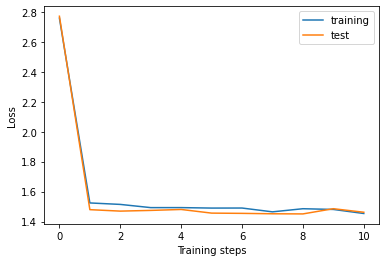

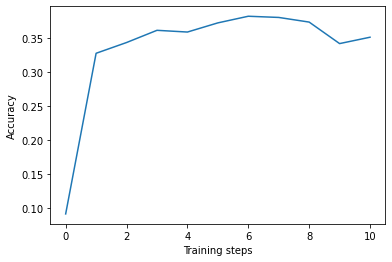

In [7]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()